In [ ]:
!pip install kaggle

In [1]:
import glob
import os
import pathlib
import shutil
import zipfile

import kaggle
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub


def download_data():
    # download dataset
    kaggle.api.dataset_download_files("vishalsubbiah/pokemon-images-and-types")
    
    # open zipfile that was downloaded...
    with zipfile.ZipFile("pokemon-images-and-types.zip") as zf:
        # and extract contents into pokemon directory
        zf.extractall("pokemon")

In [23]:
download_data()

In [2]:
df = pd.read_csv(os.path.join("pokemon", "pokemon.csv"), index_col=["Name"])
df.head()

,Type1,Type2
Name,,
bulbasaur,Grass,Poison
ivysaur,Grass,Poison
venusaur,Grass,Poison
charmander,Fire,NaN
charmeleon,Fire,NaN


In [3]:
df.profile_report()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


## Images

Let's take a look at the image data

In [4]:
img_dir = pathlib.Path("pokemon") / "images" / "images"
img_files = glob.glob(os.path.join(img_dir / "*png"))

In [5]:
len(img_files)

721

In [72]:
img_files[0]

'pokemon/images/images/dragonair.png'

pokemon/images/images/glalie.png


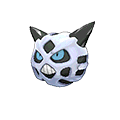

pokemon/images/images/haxorus.png


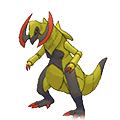

pokemon/images/images/unown.png


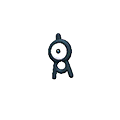

pokemon/images/images/clefable.png


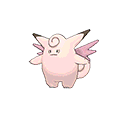

pokemon/images/images/misdreavus.png


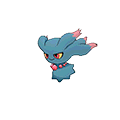

In [11]:
import random

for fn in random.choices(img_files, k=5):
    print(fn)
    display(Image.open(fn))

# The want operator

**Want:** Let's see if we can build a CNN that can look an image of a pokemon and predict its primary type.


## Organizing the data

The first step in this process is to re-organize the data

Tensorflow image loading routines expect the data to be stored in one folder per class.

So, for each of our images we will use the pokemon name in the image title together with our `df` to copy the image into a separate folder

In [12]:
fn = img_files[0]

In [87]:
img_files[0]

'pokemon/images/images/dragonair.png'

In [13]:
df.head()

,Type1,Type2
Name,,
bulbasaur,Grass,Poison
ivysaur,Grass,Poison
venusaur,Grass,Poison
charmander,Fire,NaN
charmeleon,Fire,NaN


In [98]:
for fn in img_files:
    pokename = fn.split("/")[-1]
    type1 = df.loc[pokename.split(".")[0], "Type1"]
    new_fn = pathlib.Path("pokeimages") / type1 / pokename
    new_fn.parent.mkdir(exist_ok=True, parents=True)
    shutil.copyfile(fn, new_fn)

## Preparing for training

Now that the data is organized, we need to prepare it for training

One potential issue with this dataset is that there is only one image per  pokemon.

We can simulate having many images by applying random transformations to the input images.

The `tf.keras.preprocessing.image.ImageDataGenerator` helper class can handle this and loading images to/from disk for us

Let's see how it works...

In [15]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
img_gen = (
    tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,  # convert int between [0, 255] to float in [0, 1]
        rotation_range=40,  # allow keras to rotate the image by up to 40 degress upon loading
        width_shift_range=0.2,  # shift up to 20% left and right
        height_shift_range=0.25,  # shift upt o 25% up and down
        shear_range=20,  # shearing range (shear is kinda like stretch)
        validation_split=0.15
    )
)

train_gen = (
    img_gen
    # load from our organized folder
    .flow_from_directory("pokeimages", class_mode="sparse", subset="training")
)

valid_gen = (
    img_gen
    .flow_from_directory("pokeimages", class_mode="sparse", subset="validation")
)

Found 629 images belonging to 18 classes.
Found 101 images belonging to 18 classes.


In [17]:
def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

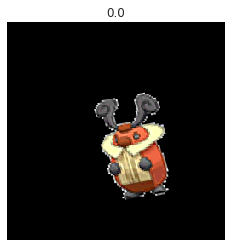

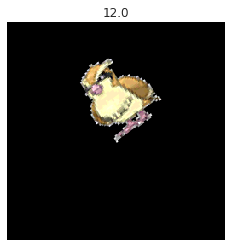

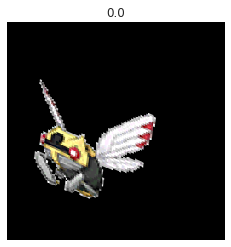

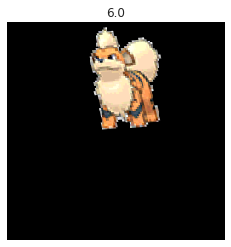

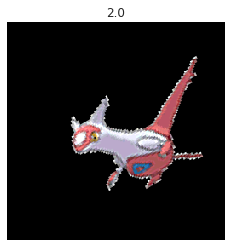

In [20]:
images, labels = next(train_gen)
for i in range(5):
    show(images[i], labels[i])

## baseline model(s)

Let's establish some baseline models so we know how well the DL model does

### Most common

For our first model we will just pick the most common type

In [21]:
popular_class = df["Type1"].value_counts().idxmax()
def most_common(image):
    return popular_class

We can evaluate the performance of this simple model by computing the share of images that are of popular class

In [24]:
df["Type1"].value_counts()[popular_class] / df.shape[0]

0.14091470951792337

### random based on distribution

For the next model we will randomly pick a class based on the frequency distribution in the data



In [27]:
freq = df["Type1"].value_counts()
dist = (freq / freq.sum()).cumsum()

def random_dist(image):
    return dist[(dist > random.random())].index[0]

We can test it via simulation

In [28]:
N = 5000
sim_types = df["Type1"].sample(N, replace=True)
classes = [random_dist(i)  for i in range(N)]
(sim_types == classes).mean()

0.076

Worse than the baseline... good to know

## Deep learning

normally we would continue to evaluate incrementally more powerful models before ending up at deep learning

A typically progression that I like to follow is 

```
summary stats > 
    linear ML with few parameters > 
    linear ML with more parameters > 
    non-linear ML > 
    deep learning with few parameters >
    deep learning with many parameters
```

We only did the first step today and are now going to skip all the way to the end

### Transfer learning

We will apply a technique called transfer learning

Transfer learning is a technique where you borrow the neural network architecture AND most of the parameter weights from a previously trained network

You will then typically re-train only the last few layers so they can calibrate themselves to the task at hand (i.e. learn to hit *your* targets)

The intuition behind why it works is that early layers in a deep network (early being closer to the raw data input) are responsible for extracting relevant features from the dataset

Later layers then take these features and learn how to combine them into a signal that can be used to hit a particular target.

In an image example with a CNN, the filters in the first layer might learn to recognize a straight line, or the color blue

The next layer might then learn to combine straight line and blue to look for a break between land and the air

The next layer might learn to combine a stright line break between blue and not-blue with green veritical layers to regocnize grass against the sky

... and so on

Training deep networks is a very tricky business and also very costly in terms of computational power.

So, transfer learning allows us to utilize the (hopefully general) feature extraction capabilities of a deep pre-trained network without having to do the training ourselves

## Keras.applications

Let's start transfer learning using keras.

The main steps are

1. pick a pretrained model from keras.applications
2. Pick a set of weights that model was trained on
3. add our own layers on the top of the pre-trained model to use for our tasks
4. Train only our new layers with our data and see how it works!

In [25]:
import tensorflow.keras as keras

In [ ]:
keras.applications.

In [38]:
n_classes = dist.shape[0]

# import keras model
base_model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)

# add a couple layers -- one to average over features
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
d1 = keras.layers.Dense(100, activation="relu")(avg)
d2 = keras.layers.Dense(50, activation="relu")(d1)

# and a second to target our `n_classes` with a softmax activation
# to generate a probabilitiy distribution over our classes
output = keras.layers.Dense(n_classes, activation="softmax")(d2)

model = keras.Model(inputs=base_model.input, outputs=output)

We can now evaluate this model directly on our data

In [39]:
images.shape

(32, 256, 256, 3)

In [40]:
prediction_dist = model.predict(images)
prediction_dist

array([[0.08755897, 0.04012327, 0.06612238, 0.05022217, 0.04437995,
        0.07736257, 0.04637228, 0.03854647, 0.06899303, 0.08129252,
        0.05676724, 0.06106914, 0.04212397, 0.05923582, 0.05796883,
        0.04421059, 0.03862916, 0.03902163],
       [0.05917609, 0.03557546, 0.08428194, 0.05263999, 0.05230928,
        0.07534506, 0.06239974, 0.05065968, 0.09530368, 0.07725312,
        0.05371078, 0.06098492, 0.03991461, 0.04540094, 0.03942331,
        0.04888877, 0.02608057, 0.040652  ],
       [0.08827384, 0.031124  , 0.0672101 , 0.03383803, 0.05259502,
        0.08804666, 0.05014134, 0.03248427, 0.07637712, 0.09339465,
        0.07939247, 0.06143621, 0.0343048 , 0.06539175, 0.03982593,
        0.04473782, 0.03025339, 0.03117256],
       [0.04848196, 0.04320525, 0.05566369, 0.04994445, 0.07077847,
        0.10329454, 0.05666687, 0.04498716, 0.05314889, 0.0776386 ,
        0.07529797, 0.05260672, 0.04255031, 0.06449929, 0.04800276,
        0.04945784, 0.03084406, 0.03293119],
    

In [41]:
preds = prediction_dist.argmax(axis=1)

In [42]:
labels

array([ 0., 12.,  0.,  6.,  2., 17., 17.,  0.,  0., 17., 10., 17., 12.,
       17., 15., 17., 16., 17., 14., 12., 17., 14.,  3.,  0., 16., 17.,
        6.,  6., 12.,  4., 14.,  0.], dtype=float32)

In [43]:
labels == preds

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

These numbers don't really mean anything yet because we haven't trained our extra layers yet

Let's do that now 

In [44]:
# first we have to "freeze" existing layers
for layer in base_model.layers:
    layer.trainable = False

# then define an optimizer and compile the model
optimizer = keras.optimizers.Adamax()
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [45]:
history = model.fit(train_gen, epochs=20, validation_data=valid_gen)

Train for 20 steps, validate for 4 steps
Epoch 1/20


/home/sglyon/anaconda3/envs/gpu2/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20/20 [==============================] - 11s 534ms/step - loss: 2.8157 - accuracy: 0.1097 - val_loss: 2.9344 - val_accuracy: 0.1485
Epoch 2/20
20/20 [==============================] - 8s 417ms/step - loss: 2.7329 - accuracy: 0.1494 - val_loss: 2.9011 - val_accuracy: 0.1287
Epoch 3/20
20/20 [==============================] - 8s 424ms/step - loss: 2.6997 - accuracy: 0.1685 - val_loss: 2.9094 - val_accuracy: 0.1683
Epoch 4/20
20/20 [==============================] - 8s 417ms/step - loss: 2.6563 - accuracy: 0.1844 - val_loss: 2.8182 - val_accuracy: 0.1881
Epoch 5/20
20/20 [==============================] - 8s 403ms/step - loss: 2.6341 - accuracy: 0.1908 - val_loss: 2.8222 - val_accuracy: 0.1782
Epoch 6/20
20/20 [==============================] - 9s 430ms/step - loss: 2.6102 - accuracy: 0.2146 - val_loss: 2.7864 - val_accuracy: 0.1683
Epoch 7/20
20/20 [==============================] - 8s 417ms/step - loss: 2.5552 - accuracy: 0.2448 - val_loss: 2.7673 - val_accuracy: 0.1881
Epoch 8/20
20/20

In [50]:
train_gen.batch_size=1000

In [52]:
images, labels = next(train_gen)

In [53]:
train_gen.class_indices

{'Bug': 0,
 'Dark': 1,
 'Dragon': 2,
 'Electric': 3,
 'Fairy': 4,
 'Fighting': 5,
 'Fire': 6,
 'Flying': 7,
 'Ghost': 8,
 'Grass': 9,
 'Ground': 10,
 'Ice': 11,
 'Normal': 12,
 'Poison': 13,
 'Psychic': 14,
 'Rock': 15,
 'Steel': 16,
 'Water': 17}

In [56]:
flying_images = images[labels == 7

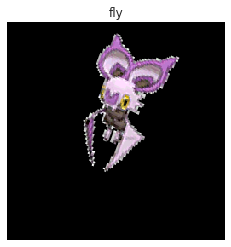

In [60]:
show(flying_images[2], "fly")